In [1]:
#importing all necessary packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Data Decription

u.data: Contains 100,000 ratings by 943 users on 1,682 items (movies). Each record has:

* User ID
* Movie ID
* Rating (1-5)
* Timestamp

u.user: Contains demographic information about the users:

* User ID
* Age
* Gender
* Occupation
* Zip Code

u.item: Contains information about the movies:

* Movie ID
* Movie title
* Release date
* Video release date
* IMDb URL
* Genres (19 genres represented as binary values)

u.genre: List of movie genres.

u.occupation: List of different occupations.

ua.train and ua.test: Splits of the u.data file, used for training and testing. The test set contains 10 ratings per user.

## Looking into dataset

**1.1. Import the csv file and list the information about the features in the loaded dataset.**

In [2]:
u_data = pd.read_csv('data/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
u_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


No missing data in this table

In [4]:
# Get summary statistics
u_data.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


Load and check other files

In [5]:
u_user = pd.read_csv('data/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
u_user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
# Check missing values
u_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


No missing values

In [7]:
# Load u.item, add headers
u_item = pd.read_csv('data/u.item', sep='|', encoding='latin-1', header=None, names=['movie_id',
                          'movie_title', 'release_date', 'video_release_date',
                          'imdb_url', 'unknown', 'action', 'adventure', 'animation', 'childrens',
                          'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir',
                          'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])
u_item

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
u_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   action              1682 non-null   int64  
 7   adventure           1682 non-null   int64  
 8   animation           1682 non-null   int64  
 9   childrens           1682 non-null   int64  
 10  comedy              1682 non-null   int64  
 11  crime               1682 non-null   int64  
 12  documentary         1682 non-null   int64  
 13  drama               1682 non-null   int64  
 14  fantasy             1682 non-null   int64  
 15  film_noir           1682 non-null   int64  
 16  horror

Note that entire video_release_date column is missing, and the column release_date and imdb_url contain missing values.

In [9]:
# Load u.occupation
u_occupation = pd.read_csv('data/u.occupation', sep='|', header=None, names=['occupation'])
u_occupation

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer
5,entertainment
6,executive
7,healthcare
8,homemaker
9,lawyer


In [10]:
# Load u.genre
u_genre = pd.read_csv('data/u.genre', sep='|', header=None, names=['genre', 'code'])

# Get list of movie genre
genre_list = u_genre['genre'].values.tolist()
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

Load training data

In [11]:
# Load in ua.train file
ua_train = pd.read_csv('data/ua.train', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ua_train

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


## Data Cleaning and Preprocessing

Since the temporal aspect of u.data can be ignored, the timestamp column can be dropped. Name the resulting movie rating dataframe as "ratings".

In [12]:
ratings = ua_train.drop('timestamp', axis=1)
ratings

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
90565,943,1047,2
90566,943,1074,4
90567,943,1188,3
90568,943,1228,3


In u_item, video_release_date is missing, this feature is redundant since there is another release_date feature.

In [13]:
# Drop video_release_date in u_item, name the resulting dataframe as movies
movies = u_item.drop('video_release_date', axis=1)

In u_item, the column release_date and imdb_url contain missing values. Find out which rows containing missing values

In [14]:
# Show the rows with missing values in movies
movies[movies.isnull().any(axis=1)]

,movie_id,movie_title,release_date,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
266,267,unknown,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The row with missing release_date and missing imdb_url is having "unknown" as movie_title, it doesn't look like a proper entry. With only 1 row having missing value, dropping them will not affect downstream analysis.

In [15]:
# Drop missing values in u_item release_date column
movies = movies.dropna(subset=['release_date'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1681 entries, 0 to 1681
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      1681 non-null   int64 
 1   movie_title   1681 non-null   object
 2   release_date  1681 non-null   object
 3   imdb_url      1679 non-null   object
 4   unknown       1681 non-null   int64 
 5   action        1681 non-null   int64 
 6   adventure     1681 non-null   int64 
 7   animation     1681 non-null   int64 
 8   childrens     1681 non-null   int64 
 9   comedy        1681 non-null   int64 
 10  crime         1681 non-null   int64 
 11  documentary   1681 non-null   int64 
 12  drama         1681 non-null   int64 
 13  fantasy       1681 non-null   int64 
 14  film_noir     1681 non-null   int64 
 15  horror        1681 non-null   int64 
 16  musical       1681 non-null   int64 
 17  mystery       1681 non-null   int64 
 18  romance       1681 non-null   int64 
 19  sci_fi     

For the other 2 entries with missing imdb_url, Google search shows that these 2 movies are less popular and their IMDB pages are indeed not available. As this imdb_url feature is not useful in analysis later, we don't need to handle missing values for now.

The release_date feature can be converted to release_year in number format, which could be useful in later stage to recommend movie from the same year.

In [16]:
# Convert release_date to release year (integer without decimal)
movies['release_date'] = pd.to_datetime(u_item['release_date'])
movies['release_date'] = movies['release_date'].dt.year.astype(int)

# Rename column
movies = movies.rename(columns={'release_date': 'release_year'})
movies

,movie_id,movie_title,release_year,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Look for duplicates in the ratings data.

In [17]:
# Identify duplicates based on user_id and movie_id
duplicates = ratings[ratings.duplicated(subset=['user_id', 'movie_id'], keep=False)]

# Display the duplicate rows
duplicates

,user_id,movie_id,rating


In [18]:
# Check duplicate in movies
movies[movies.duplicated()]

,movie_id,movie_title,release_year,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western


There is no duplicate entries in both data

Outlier handling is not required in this case.

Next, check whether all movie ids in data are included in movies

In [19]:
# check whether all movie ids in data are included in u_item
ratings['movie_id'].isin(movies['movie_id']).value_counts()

,count
movie_id,
True,90562
False,8


In [20]:
# Show which item_id are not in u_item
ratings[~ratings['movie_id'].isin(movies['movie_id'])]

,user_id,movie_id,rating
256,1,267,4
445,5,267,4
12227,130,267,5
23647,268,267,3
27988,297,267,3
43231,422,267,4
54139,532,267,3
79838,833,267,1


This movie_id 267 is the movie with 'unknown' title, which was dropped earlier. Since this item is not in movies list, we can update the ratings dataframe based on movies present in movies.

In [21]:
print(ratings.shape)
available_movie_id = movies['movie_id'].unique()
ratings = ratings[ratings.movie_id.isin(available_movie_id)]
print(ratings.shape)

(90570, 3)
(90562, 3)


## Exploratory Data Analysis

Plot histogram of ratings.

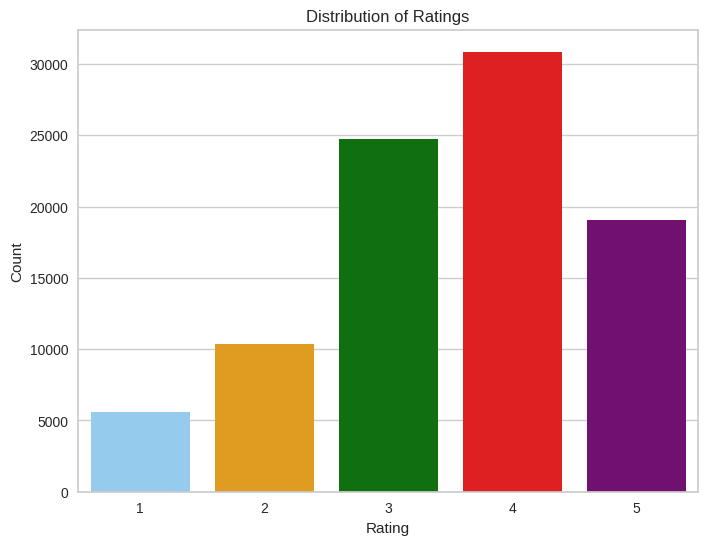

In [22]:
# Distribution of Ratings
my_palette = ["#87cefa", "#ffa500", "#008000", "#ff0000", "#800080"]
plt.figure(figsize=(8, 6))
# sns.countplot(data=ratings, x='rating')
sns.countplot(data=ratings, x='rating', palette=my_palette)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Plot the histogram of ratings across users.

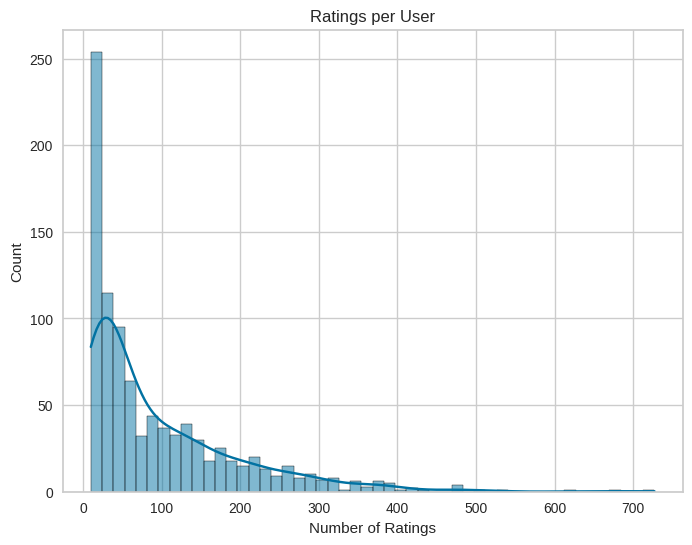

In [23]:
# Ratings per User
user_ratings_count = ratings.groupby('user_id')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(user_ratings_count, bins=50, kde=True)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

Long-tail distribution, most user have < 300 ratings.

Plot the histogram of ratings across movies

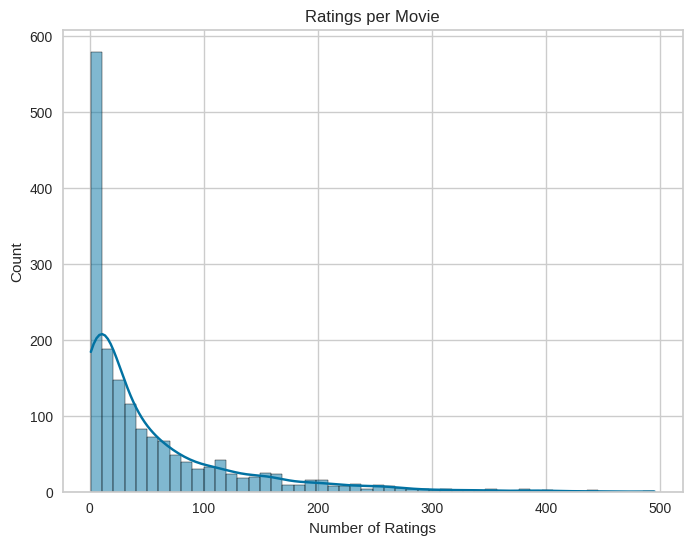

In [24]:
# Ratings per movie
movie_ratings_count = ratings.groupby('movie_id')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(movie_ratings_count, bins=50, kde=True)
plt.title('Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

This seems to be a long-tail distribution, some movies have 0 or only a few ratings.

Next, we can plot average rating vs. number of ratings. Before that, we need to create these 2 features in movies dataframe.

In [25]:
# In movies, create ratings_count column, total rating count for each movie
ratings_count = ratings.groupby('movie_id')['rating'].count()
movies['ratings_count'] = movies['movie_id'].map(ratings_count)
movies['ratings_count']


,ratings_count
0,392.0
1,121.0
2,85.0
3,198.0
4,79.0
...,...
1677,1.0
1678,1.0
1679,1.0
1680,1.0


In [26]:
# Create average rating
average_rating = ratings.groupby('movie_id')['rating'].mean()
movies['average_rating'] = movies['movie_id'].map(average_rating)
movies['average_rating']

,average_rating
0,3.859694
1,3.198347
2,3.058824
3,3.545455
4,3.291139
...,...
1677,1.000000
1678,3.000000
1679,2.000000
1680,3.000000


Plot average rating and number of ratings.

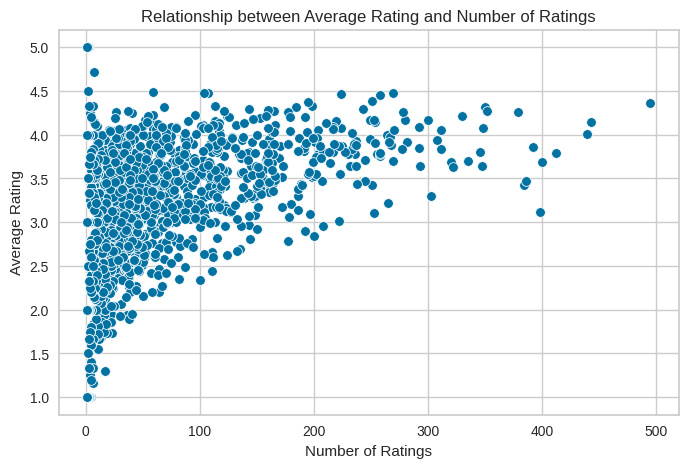

In [27]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ratings_count', y='average_rating', data=movies)
plt.title('Relationship between Average Rating and Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

Again, most movies rae having < 100 ratings. Majority of average rating is the range between 2.0 and 4.0.

Next, let's find out the top 10 most popular movies

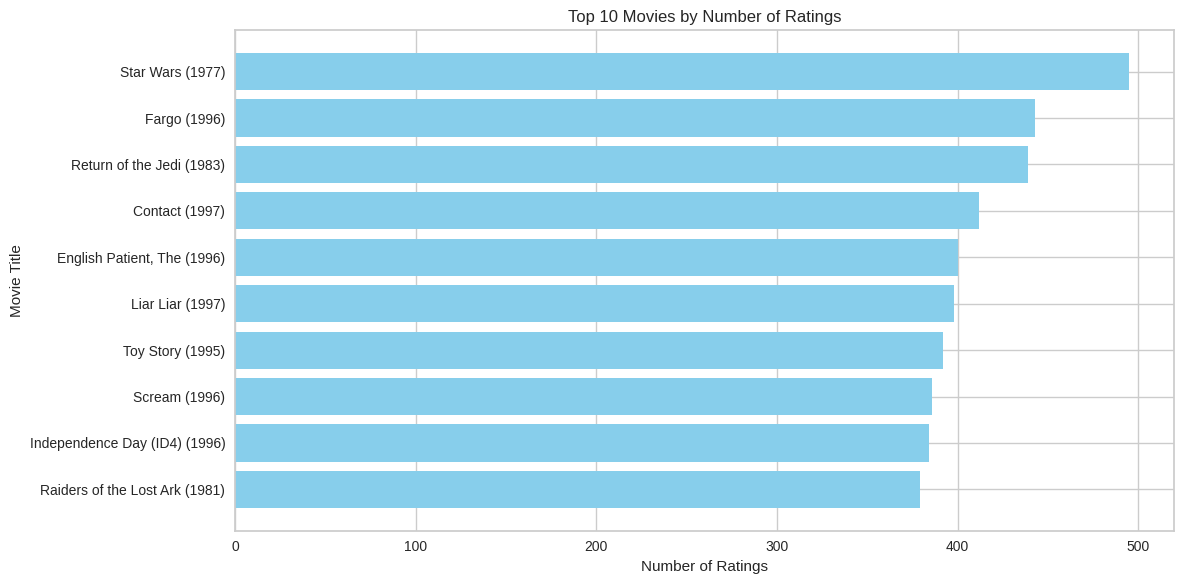

In [28]:
# Calculate the number of ratings for each movie
movie_ratings_count = ratings['movie_id'].value_counts().reset_index()
movie_ratings_count.columns = ['movie_id', 'ratings_count']

# Sort the movies based on the number of ratings in descending order
movie_ratings_count = movie_ratings_count.sort_values(by='ratings_count', ascending=False)

# Define the number of top-rated movies to plot
num_top_movies_to_plot = 10

# Select the top N movies
top_movies = movie_ratings_count.head(num_top_movies_to_plot)

# Get movie titles for the top-rated movies
top_movies_titles = [movies[movies['movie_id'] == movie_id]['movie_title'].values[0] for movie_id in top_movies['movie_id']]

# Create a bar plot to visualize the number of ratings for the top-rated movies
plt.figure(figsize=(12, 6))
plt.barh(top_movies_titles, top_movies['ratings_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title(f'Top {num_top_movies_to_plot} Movies by Number of Ratings')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest-rated movie at the top
plt.tight_layout()
plt.show()

## Recommendation using Collaborative Filtering

Load in the train.csv file, which has been preprocessed already.

In [29]:
ratings = pd.read_csv('data/train.csv')

# Rename item_id to movie_id
ratings = ratings.rename(columns={'item_id': 'movie_id'})
ratings

,user_id,movie_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime
...,...,...,...,...,...,...,...,...,...
90565,943,1047,2,22,M,student,Texas,1996.0,Comedy
90566,943,1074,4,22,M,student,Texas,1994.0,Comedy
90567,943,1188,3,22,M,student,Texas,1990.0,Action
90568,943,1228,3,22,M,student,Texas,1995.0,Action


Compute the minimum and maximum values of movie_id and user_id.

In [30]:
ratings['movie_id'].max(), ratings['movie_id'].min(), ratings['user_id'].max(), ratings['user_id'].min()

(1682, 1, 943, 1)

Obtain a matrix of user movie ratings, where users and movies are along rows and columns, respectively.

In [31]:
# Sample DataFrame
t_data = ratings[['user_id', 'movie_id', 'rating']]

# Pivot the DataFrame
pivoted_df_na = t_data.pivot(index='user_id', columns='movie_id', values='rating')

# Remove the index and column names
pivoted_df_na.index.name = None
pivoted_df_na.columns.name = None
pivoted_df_na = pivoted_df_na.dropna(axis=1, how='all')
pivoted_df = pivoted_df_na.fillna(0)
pivoted_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
pivoted_df.shape

(943, 1680)

Calculate singular value decomposition (SVD) of user-movie ratings matrix.

In [33]:
from numpy.linalg import svd
matrix = pivoted_df.values
u, s, vh = svd(matrix, full_matrices=False)

Check shape of each output matrix

In [34]:
u.shape, s.shape, vh.shape

((943, 943), (943,), (943, 1680))

### User-based collaborative filtering

In [35]:
# function to calculate cosine similarity
# np.dot() computes the dot product of two arrays
def cosine_similarity(x,y):
    return np.dot(x, y)/ (np.linalg.norm(x) * np.linalg.norm(y))

# function to compute similar users, with N latent factors
def similar_users(user_id, u1, n_elements=5):
    # Create a dictionary to store similarity scores
    similarity_dict = {}

    # Extract the first n_elements from u1
    u2 = u1[:, :n_elements]

    # Iterate over each user (column) in u2
    for col in range(0, u2.shape[0]):
        # Calculate cosine similarity between the user_id's row and the current user's row (should be u2[user_id-1,:])
        similarity_dict[col] = cosine_similarity(u2[user_id-1, :], u2[col, :])  # In W5 tutorial: u2[user_id, :]

    # Return the dictionary of similarity scores
    return similarity_dict

In [36]:
vh.shape, u.shape, s.shape

((943, 1680), (943, 943), (943,))

In [37]:
# Set dimensions for sigma matrix
m = vh.shape[0]
n = vh.shape[1]

# Initialize sigma matrix with zeros
sigma = np.zeros((m, m))

# Populate the diagonal elements of sigma with singular values from s
for i in range(min(m, n)):
    sigma[i, i] = s[i]

In [38]:
# Function to recommend movies, output movie_id
def recommend_movies(uid, u, sigma, pivoted_df, t_data, movies, top_k=6, n_elements=20, rating_threshold=4):
    """
    Recommend top N movies to a user based on similar users' preferences.

    Parameters:
    - uid: int, user ID for which to make recommendations.
    - u: np.array, user factors from matrix factorization.
    - sigma: np.array, singular values from matrix factorization.
    - pivoted_df: DataFrame, pivoted user-movie rating DataFrame with user IDs as index.
    - t_data: DataFrame, original user-movie ratings DataFrame.
    - movies: DataFrame, movie metadata with movie_id and movie_title columns.
    - n_elements: int, number of similar users to consider (default is 20).
    - rating_threshold: float, minimum predicted rating for recommended movies (default is 3.5).
    - top_k: int, number of top movie recommendations to return (default is 6).

    Returns:
    - list of tuples with (movie_id, predicted_rating)
    """
    # Calculate user factor by multiplying U and Sigma
    user_factor = np.dot(u, sigma)

    # Compute similar users for the specified user
    user_predictions = similar_users(uid, user_factor, n_elements)

    # Sort similar users by similarity score in descending order, exclude the current user
    sim_user = [(ind+1, sim) for ind, sim in user_predictions.items() if ind+1 != uid]
    sim_user = sorted(sim_user, key=lambda x: x[1], reverse=True)

    # Get the most similar user's user ID
    most_similar_user_id = sim_user[0][0]

    # Get the corresponding user IDs from the pivoted DataFrame
    user_id_recommend = most_similar_user_id
    user_id_target = uid  #pivoted_df.index[uid]  # In tutorial code: pivoted_df.index[uid]

    # Extract unique movie IDs rated by each user
    movies_user_recommend = t_data[t_data['user_id'] == user_id_recommend]['movie_id'].unique()
    movies_user_target = t_data[t_data['user_id'] == user_id_target]['movie_id'].unique()

    # Find movies rated by the recommended user but not by the target user
    probable_movies = set(movies_user_recommend) - set(movies_user_target)

    # Calculate the mean rating for each probable movie
    probable_movie_ratings = {}
    for movie_id in probable_movies:
        probable_movie_ratings[movie_id] = np.mean(t_data[t_data['movie_id'] == movie_id]['rating'])

    # Sort probable movies by mean rating in descending order
    movie_recommendations = sorted(probable_movie_ratings.items(), key=lambda x: x[1], reverse=True)

    # Get the top N movie recommendations with ratings above the threshold
    top_recommendations = [movie_info for movie_info in movie_recommendations if movie_info[1] >= rating_threshold][:top_k]
    return top_recommendations

# Function to prepare a list of top movie recommendations with titles, release years, and ratings
def prepare_recommendations(top_recommendations, movies):
    recommendations = []
    for movie_id, rating in top_recommendations:
        movie_info = movies[movies['movie_id'] == movie_id]
        if not movie_info.empty:
            title = movie_info['movie_title'].values[0]
            release_year = movie_info['release_year'].values[0]
            recommendations.append((title, release_year, rating))
        else:
            recommendations.append((f"Movie ID {movie_id} not found", None, rating))

    return recommendations

# Recommend movie for a selected user
uid = 1
top_recomm = recommend_movies(uid=uid, u=u, sigma=sigma, pivoted_df=pivoted_df, t_data=t_data, movies=movies)
top_6_recommendations = prepare_recommendations(top_recomm, movies)

# Print the top 6 movie recommendations with titles, release years, and ratings
for title, year, rating in top_6_recommendations:
    if year:
        print(f"Movie Title: {title}, Release Year: {year}, Predicted Rating: {rating:.2f}")
    else:
        print(f"Movie Title: {title}, Predicted Rating: {rating:.2f}")


Movie Title: Close Shave, A (1995), Release Year: 1996, Predicted Rating: 4.48
Movie Title: Casablanca (1942), Release Year: 1942, Predicted Rating: 4.46
Movie Title: One Flew Over the Cuckoo's Nest (1975), Release Year: 1975, Predicted Rating: 4.29
Movie Title: North by Northwest (1959), Release Year: 1959, Predicted Rating: 4.29
Movie Title: Vertigo (1958), Release Year: 1958, Predicted Rating: 4.27
Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963), Release Year: 1963, Predicted Rating: 4.26


## Evaluation on test data

In [39]:
# Load the test data
test_data = pd.read_csv('data/ua.test', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
test_data

,user_id,movie_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201
...,...,...,...,...
9425,943,232,4,888639867
9426,943,356,4,888639598
9427,943,570,1,888640125
9428,943,808,4,888639868


For each user in test data, compile the list of movies the user rated, and get the movie likes with rating 4 or above

In [40]:
# For each user in test_data, get the list of movie_id with ratings >= 4
test_like_movies = test_data[test_data['rating'] >= 4].groupby('user_id')['movie_id'].apply(list)
test_like_movies

,movie_id
user_id,
1,"[20, 33, 61, 160, 171, 202, 265]"
2,"[13, 50, 251, 292, 297]"
3,"[328, 331]"
4,"[50, 260, 288, 294, 303, 354, 357, 361]"
5,"[1, 17]"
...,...
939,"[121, 258, 409, 476, 689, 993, 1054, 1190]"
940,"[66, 272, 315, 655]"
941,"[7, 15, 117, 124, 147, 181, 257, 258, 475, 993]"


In [41]:
# Count number of rows in test_like_movies
len(test_like_movies)

934

Total number of users is 943, therefore there are 9 users have no rating data in test dataset.

Use the user-based collaborative filtering built earlier to recommend 6 movies for each user.

In [42]:
# Initiate counters
correct_count = 0
total_count = 0

# predict movie for each user in test_like_movies
for uid in test_like_movies.index:
  #print("uid is: ", uid)

  # Use the user-based collaborative filtering to recommend 6 movies for each user
  top_k_movies = recommend_movies(uid=uid, u=u, sigma=sigma, pivoted_df=pivoted_df, t_data=t_data, movies=movies, top_k=6)
  #print("Top 6 movies: ", top_k_movies)

  #recommended_movies = pd.concat([recommended_movies, pd.DataFrame(top_movies, columns=['movie_id', 'predicted_rating'])])
  total_count += len(top_k_movies)

  for movie_id, rating in top_k_movies:
    # Check whether movie_id is present in test_like_movies
    if movie_id in test_like_movies[uid]:
      correct_count += 1
      #print("Correct prediction: ", movie_id)

print("Correct count: ", correct_count)
print("Total count: ", total_count)

Correct count:  393
Total count:  3748


Calculate the percentage of correct predictions, which is the Precision@K (explained below).

In [43]:
# Calculate the percentage of correct predictions
precision = correct_count / total_count
print(f"Percentage of correct predictions for K=6 : {precision* 100:.2f}%")

Percentage of correct predictions for K=6 : 10.49%


Calculate recall@K

In [44]:
# recall = Number of relevant items in top K recommendations / Total number of relevant items
recall = correct_count / len(test_data[test_data['rating'] >= 4])
print(f"Recall for K=6 : {recall* 100:.2f}%")

Recall for K=6 : 7.19%


Calcualte F1 score @K

In [45]:
# F1@K = 2X (Precision@K X Recall@K) / (Precision@K + Recall@K)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score for K=6 : {f1:.2f}")

F1 score for K=6 : 0.09


Next, for different values of K (1 to 5), we calculate the mean percentage of correct predictions.

In [46]:
# For K from 1 to 5, calculate the % of correct prediction
precision_list = []
precision_list.append(precision)
recall_list = []
recall_list.append(recall)
f1_list = []
f1_list.append(f1)

for k in range(1, 6):
  # Initiate counters
  correct_count = 0
  total_count = 0

  # predict movie for each user in test_like_movies
  for uid in test_like_movies.index:
    # Use the user-based collaborative filtering to recommend 6 movies for each user
    top_k_movies = recommend_movies(uid=uid, u=u, sigma=sigma, pivoted_df=pivoted_df, t_data=t_data, movies=movies, top_k=k)
    #print("Top 6 movies: ", top_k_movies)

    #recommended_movies = pd.concat([recommended_movies, pd.DataFrame(top_movies, columns=['movie_id', 'predicted_rating'])])
    total_count += len(top_k_movies)

    for movie_id, rating in top_k_movies:
      # Check whether movie_id is present in test_like_movies
      if movie_id in test_like_movies[uid]:
        correct_count += 1

  print("For K=", k)
  print("Correct count: ", correct_count)
  print("Total count: ", total_count)
  precisionK = correct_count / total_count
  print(f"Percentage of correct predictions for K={k} : {precisionK* 100:.2f}%")
  precision_list.append(precisionK)
  recallK = correct_count / len(test_data[test_data['rating'] >= 4])
  print(f"Recall for K={k} : {recallK* 100:.2f}%")
  recall_list.append(recallK)
  f1K = 2 * (precisionK * recallK) / (precisionK + recallK)
  print(f"F1 score for K={k} : {f1K:.2f}\n")
  f1_list.append(f1K)

For K= 1
Correct count:  110
Total count:  816
Percentage of correct predictions for K=1 : 13.48%
Recall for K=1 : 2.01%
F1 score for K=1 : 0.04

For K= 2
Correct count:  186
Total count:  1523
Percentage of correct predictions for K=2 : 12.21%
Recall for K=2 : 3.40%
F1 score for K=2 : 0.05

For K= 3
Correct count:  269
Total count:  2155
Percentage of correct predictions for K=3 : 12.48%
Recall for K=3 : 4.92%
F1 score for K=3 : 0.07

For K= 4
Correct count:  315
Total count:  2721
Percentage of correct predictions for K=4 : 11.58%
Recall for K=4 : 5.76%
F1 score for K=4 : 0.08

For K= 5
Correct count:  359
Total count:  3256
Percentage of correct predictions for K=5 : 11.03%
Recall for K=5 : 6.56%
F1 score for K=5 : 0.08



In [47]:
# Mean percentage of correct predictions for different values of K
print(f"Mean percentage of correct predictions for different values of K: {np.mean(precision_list)*100:.2f}%")
print(f"Mean recall for different values of K: {np.mean(recall_list)*100:.2f}%")
print(f"Mean F1 score for different values of K: {np.mean(f1_list):.2f}")

Mean percentage of correct predictions for different values of K: 11.88%
Mean recall for different values of K: 4.97%
Mean F1 score for different values of K: 0.07


Explanation for evaluation metrics:

1. Precision@K = Number of relevant items in top K recommendations / K

Interpretation: Higher Precision@K indicates better recommendation relevance within the top K items.

2. Recall@K = Number of relevant items in top K recommendations / Total number of relevant items

Interpretation: Higher Recall@K indicates that more relevant items are successfully recommended to the user.

3. F1 Score @K = 2X (Precision@K X Recall@K) / (Precision@K + Recall@K)

Interpretation: An F1 score close to 1 indicates a balance of high precision and recall.